<a href="https://colab.research.google.com/github/eyaler/workshop/blob/master/output/nn_6_novelty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6. Novelty detection


In [1]:
%tensorflow_version 1.x
!pip install keras==2.2.5
!pip install livelossplot
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras import Input, Model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import mnist, cifar10
from keras.utils import to_categorical
from livelossplot import PlotLossesKeras
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
!nvidia-smi -L

TensorFlow 1.x selected.


Using TensorFlow backend.


GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-97d33b85-081a-7288-e6c4-7ecd4b94fddf)


In [2]:
# set random seeds for more reproducible results
from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(43)

In [3]:
# load dataset
#(raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = mnist.load_data()
(raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = cifar10.load_data()
print(raw_x_train.shape, raw_y_train.shape)
gray = False
if len(raw_x_train.shape)==4 and gray:
    raw_x_train = np.mean(raw_x_train, axis=-1, keepdims=True)
    raw_x_test = np.mean(raw_x_test, axis=-1, keepdims=True)
if len(raw_x_train.shape)==3:
    raw_x_train = np.expand_dims(raw_x_train, axis=-1)
    raw_x_test = np.expand_dims(raw_x_test, axis=-1)
train_size = len(raw_y_train)
test_size = len(raw_y_test)
xdim = raw_x_train.shape[1]
ydim = raw_x_train.shape[2]
cdim = raw_x_train.shape[3]
print(raw_x_train.dtype, raw_y_train.dtype)

(50000, 32, 32, 3) (50000, 1)
uint8 uint8


[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]
[6]


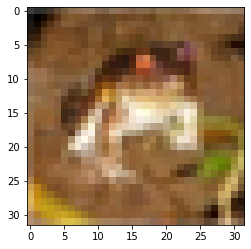

In [4]:
print(raw_x_train[0])
print(raw_y_train[0])
if gray:
    plt.imshow(raw_x_train[0][..., 0], cmap='gray')
else:
    plt.imshow(raw_x_train[0])

In [5]:
print(np.min(raw_x_train), np.max(raw_x_train), np.median(raw_x_train))
print(np.unique(raw_y_train, return_counts=True))
print(np.unique(raw_y_test, return_counts=True))

0 255 117.0
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))


In [6]:
x_train, y_train = shuffle(raw_x_train, raw_y_train, random_state=44)
x_train = x_train/255
x_test = raw_x_test/255
y_test = raw_y_test
x_train = np.asarray([x for x,y in zip(x_train,y_train) if y[0]!=9])
y_train = np.asarray([y for y in y_train if y[0]!=9])

n_classes = len(np.unique(y_train))
print(n_classes)
print(np.unique(y_train, return_counts=True))
y_train = to_categorical(y_train, n_classes)

9
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))


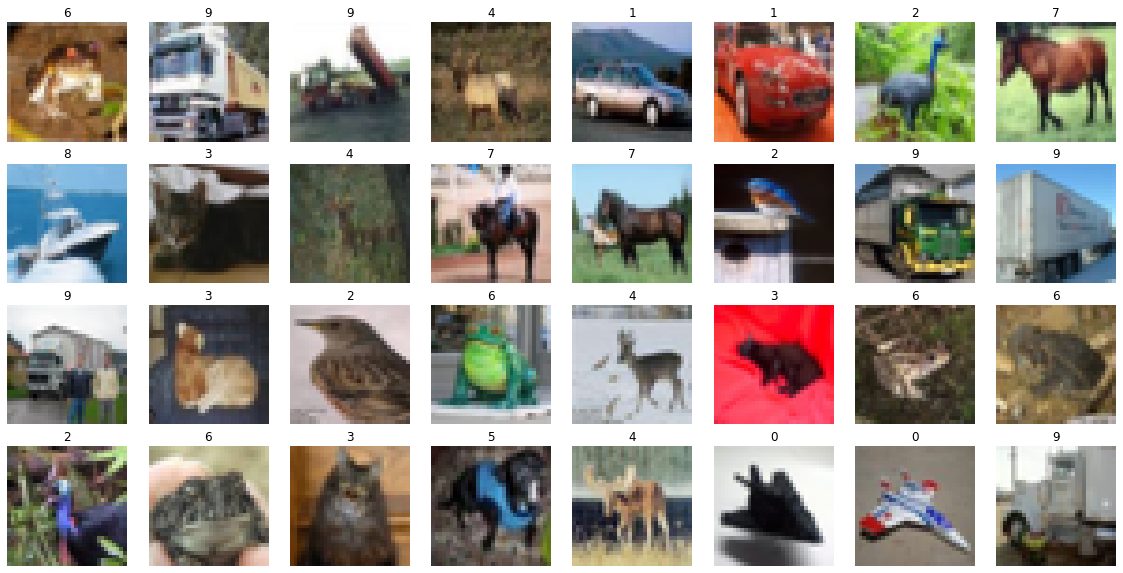

In [7]:
from mpl_toolkits.axes_grid1 import ImageGrid

#helper function to plot in grids
def show_grid(image_list,nrows,ncols,label_list=None,show_labels=False,savename=None,figsize=(10,10),showaxis='off'):
    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis('off')
        if show_labels:
            ax.set_title(label_list[i])
    if savename != None:
        plt.savefig(savename,bbox_inches='tight')

show_grid(raw_x_train[:32],4,8,label_list=np.squeeze(raw_y_train[:32]),show_labels=True,figsize=(20,10))

In [8]:
def get_model(bn):
    inputs = Input(shape=(xdim, ydim, cdim))
    f = Conv2D(filters=32, kernel_size=3, activation='relu')(inputs)
    if bn:
        f = BatchNormalization()(f)
    f = Conv2D(filters=32, kernel_size=3, activation='relu')(f)
    if bn:
        f = BatchNormalization()(f)
    f = MaxPooling2D()(f)
    f = Dropout(0.25)(f)
    f = Conv2D(filters=64, kernel_size=3, activation='relu')(f)
    if bn:
        f = BatchNormalization()(f)
    f = Conv2D(filters=64, kernel_size=3, activation='relu')(f)
    if bn:
        f = BatchNormalization()(f)
    f = MaxPooling2D()(f)
    f = Dropout(0.25)(f)
    f = Flatten()(f)
    f = Dense(512, activation='relu', name='embeddings')(f)
    f = Dropout(0.5)(f)
    f = Dense(n_classes, name='logits')(f)
    outputs = Activation('softmax')(f)
    return Model(inputs=inputs, outputs=outputs)

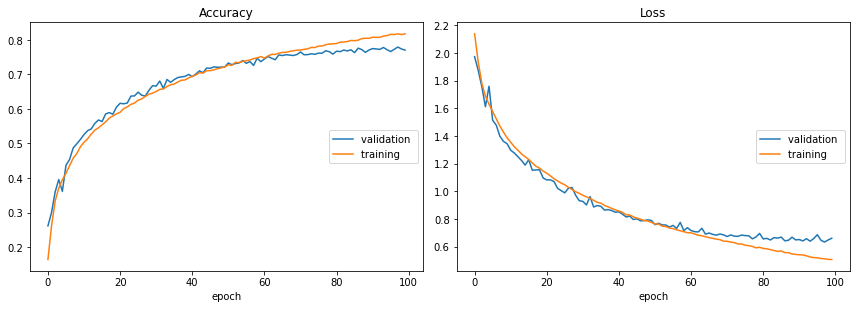

Accuracy
	validation       	 (min:    0.261, max:    0.779, cur:    0.770)
	training         	 (min:    0.164, max:    0.818, cur:    0.818)
Loss
	validation       	 (min:    0.633, max:    1.972, cur:    0.660)
	training         	 (min:    0.507, max:    2.138, cur:    0.507)


In [9]:
model = get_model(bn=False)
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=100, validation_split=0.2, callbacks=[PlotLossesKeras()])

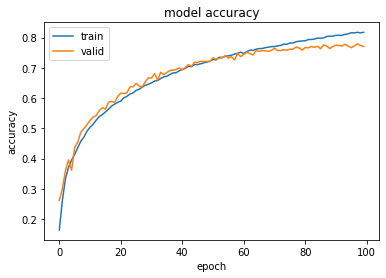

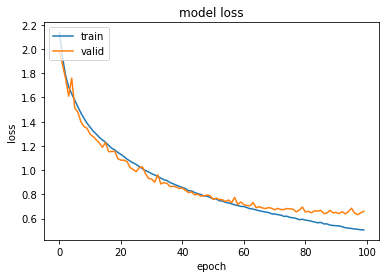

In [10]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [11]:
get_logits = Model(inputs=model.input, outputs=model.get_layer('logits').output)

(array([0.02616027, 0.08196883, 0.10173438, 0.09243295, 0.08371284,
        0.05290189, 0.04592579, 0.02964831, 0.0267416 , 0.01220813,
        0.00639473, 0.00813874, 0.00406938, 0.00465072, 0.00116268,
        0.00116268, 0.00058134, 0.00116268, 0.        , 0.00058134]),
 array([ 2.2110527,  3.9312184,  5.6513844,  7.37155  ,  9.091716 ,
        10.811882 , 12.532047 , 14.2522135, 15.972379 , 17.692545 ,
        19.41271  , 21.132875 , 22.853043 , 24.573208 , 26.293373 ,
        28.01354  , 29.733706 , 31.45387  , 33.174038 , 34.894203 ,
        36.61437  ], dtype=float32),
 <a list of 20 Patch objects>)

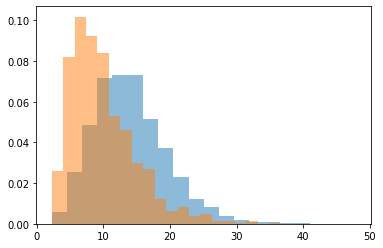

In [12]:
logits = get_logits.predict(x_test)
max_logits = np.max(logits, axis=-1)-np.min(logits, axis=-1)
logit_normal = [p for p,y in zip(max_logits, y_test) if y<9]
logit_novel = [p for p,y in zip(max_logits, y_test) if y==9]
plt.hist(logit_normal, 20, density=True, alpha=0.5, label='normal')
plt.hist(logit_novel, 20, density=True, alpha=0.5, label='novel')

In [13]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca')

x_normal = np.asarray([x for x,y in zip(x_test,y_test) if y < 9])
x_novel = np.asarray([x for x,y in zip(x_test,y_test) if y==9])

get_emb = Model(inputs=model.input, outputs=model.get_layer('embeddings').output)
code_normal = np.reshape(get_emb.predict(x_normal),(-1,256))
code_novel = np.reshape(get_emb.predict(x_novel),(-1,256))


low = tsne.fit_transform(np.vstack((code_normal,code_novel)))

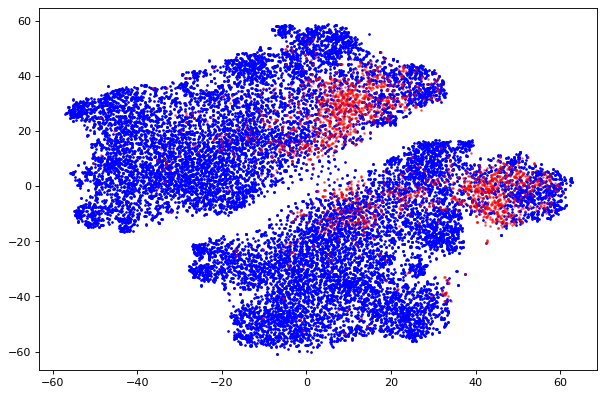

In [14]:
t_normal = low[:len(code_normal)]
t_novel = low[len(code_normal):]
fig=plt.figure(figsize=(9,6), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(t_normal[:,0],t_normal[:,1],color='b',s=2)
plt.scatter(t_novel[:,0],t_novel[:,1],color='r',alpha=0.5,s=2)
plt.show()